# Analise de Dados para casos de assassinatos de pessoas transexuais 

## Estagio inicial para importar bibliotecas utilizadas e definir parametros

In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True) 

import folium
from folium import plugins

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import jarque_bera


## Visualização inical do DataFrame

In [46]:
file = 'tdor_export.csv'
df = pd.read_csv(file, sep=',', parse_dates=['Date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4537 entries, 0 to 4536
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Name            4537 non-null   object        
 1   Age             3004 non-null   object        
 2   Birthdate       87 non-null     object        
 3   Photo           1947 non-null   object        
 4   Photo source    1787 non-null   object        
 5   Thumbnail       4537 non-null   object        
 6   Date            4537 non-null   datetime64[ns]
 7   TDoR list ref   4013 non-null   object        
 8   Location        4425 non-null   object        
 9   Country         4537 non-null   object        
 10  Country Code    4535 non-null   object        
 11  Latitude        4537 non-null   float64       
 12  Longitude       4537 non-null   float64       
 13  Category        4537 non-null   object        
 14  Cause of death  4537 non-null   object        
 15  Desc

## Visualizando as primeiras colunas do arquivo

In [47]:
df.head()

Name  Age Birthdate  \
0            Laverne Turner   21       NaN   
1              Name Unknown  NaN       NaN   
2  Maxwell/Michelle Confait   26       NaN   
3             Jamie D. Ford  NaN       NaN   
4           William Battles  NaN       NaN   

                                            Photo  \
0                                             NaN   
1                                             NaN   
2  photos/1972_04_21_Maxwell-Michelle-Confait.jpg   
3                                             NaN   
4                                             NaN   

                                        Photo source  \
0                                                NaN   
1                                                NaN   
2  https://web.archive.org/web/20190219220503/htt...   
3                                                NaN   
4                                                NaN   

                                           Thumbnail       Date  \
0                                     trans_flag.jpg 1970-03-07   
1                                     trans_flag.jpg 1972-01-31   
2  thumbnails/1972_04_21_Maxwell-Michelle-Confait... 1972-04-21   
3                                     trans_flag.jpg 1973-01-31   
4                                     trans_flag.jpg 1973-11-24   

                                       TDoR list ref                 Location  \
0           tdor.info/7 Mar 1970/Larry Lavern Turner  Los Angeles, California   
1  tdor.info/Jan 1972/Unidentified crossdressed male                 New York   
2              tdor.info/21 Apr 1972/Maxwell Confait    Catford, South London   
3                   tdor.info/Jan 1973/Jamie D. Ford    San Diego, California   
4              tdor.info/24 Nov 1973/William Battles    South Bronx, New York   

          Country Country Code   Latitude   Longitude  Category  \
0             USA           US  34.007527 -118.258707  violence   
1             USA           US  40.713054  -74.007228  violence   
2  United Kingdom           GB  51.444730   -0.022790  violence   
3             USA           US  32.715760 -117.163817  violence   
4             USA           US  40.907500  -73.896560  violence   

  Cause of death                                        Description  \
0           shot  Laverne was a sex worker who was shot by the L...   
1        stabbed  The victim was stabbed above the the right eye...   
2      strangled  Maxwell/Michelle was burned alive. Three teena...   
3        stabbed  Jamie was stabbed.\n\nAccording to police, the...   
4         beaten  William was beaten and sexually mutilated by m...   

                                               Tweet  \
0  Laverne Turner was 21 and was shot in Los Ange...   
1          Name Unknown was stabbed in New York, USA   
2  Maxwell/Michelle Confait was 26 and was strang...   
3  Jamie D. Ford was stabbed in San Diego, Califo...   
4  William Battles was beaten in South Bronx, New...   

                                           Permalink               QR code  
0  https://tdor.translivesmatter.info/reports/197...  qrcodes/33e6cd63.png  
1  https://tdor.translivesmatter.info/reports/197...  qrcodes/460ce033.png  
2  https://tdor.translivesmatter.info/reports/197...  qrcodes/817214c3.png  
3  https://tdor.translivesmatter.info/reports/197...  qrcodes/b84d2d6d.png  
4  https://tdor.translivesmatter.info/reports/197...  qrcodes/453dc563.png

### Agrupando a contagem de casos, por data e Pais, Localização, Causa de morte, Categoria, Descrições e coordernadas

### Para melhor compreensão os nomes das colunas serão traduzidas

In [48]:

df_final = df.groupby(['Date', 'Country','Location','Country Code','Cause of death','Category','Description','Longitude', 'Latitude'])['Name'].count().reset_index()

df_final.columns = ['Data','Pais', 'Localizacao', 'Codigo do pais', 'Causa da morte', 'Categoria', 'Descricao', 'Longitude', 'Latitude', 'Nome']

df_final

Data            Pais                Localizacao Codigo do pais  \
0    1970-03-07             USA    Los Angeles, California             US   
1    1972-01-31             USA                   New York             US   
2    1972-04-21  United Kingdom      Catford, South London             GB   
3    1973-01-31             USA      San Diego, California             US   
4    1973-11-24             USA      South Bronx, New York             US   
...         ...             ...                        ...            ...   
4375 2022-01-22          Mexico           Ciudad de México             MX   
4376 2022-01-23          Brazil            Timon, Maranhão             BR   
4377 2022-01-26        Pakistan  Bannu, Khyber Pakhtunkhwa             PK   
4378 2022-01-29         Ecuador           Tilalles, El Oro             EC   
4379 2022-01-30          Brazil  Cabo Frio, Rio de Janeiro             BR   

          Causa da morte Categoria  \
0                   shot  violence   
1                stabbed  violence   
2              strangled  violence   
3                stabbed  violence   
4                 beaten  violence   
...                  ...       ...   
4375             stabbed  violence   
4376  stoned and stabbed  violence   
4377                shot  violence   
4378                shot  violence   
4379              beaten  violence   

                                              Descricao   Longitude  \
0     Laverne was a sex worker who was shot by the L... -118.258707   
1     The victim was stabbed above the the right eye...  -74.007228   
2     Maxwell/Michelle was burned alive. Three teena...   -0.022790   
3     Jamie was stabbed.\n\nAccording to police, the... -117.163817   
4     William was beaten and sexually mutilated by m...  -73.896560   
...                                                 ...         ...   
4375  Ximena died in hospital after being attacked i...  -99.217104   
4376  Paulinha was found dead after being beaten aro...  -42.837359   
4377  The victim was shot during a fight between two...   70.571056   
4378  León Pindo Cuenca was shot by hitmen who inter...  -79.857645   
4379  The body of the victim was found on the mornin...  -42.020066   

       Latitude  Nome  
0     34.007527     1  
1     40.713054     1  
2     51.444730     1  
3     32.715760     1  
4     40.907500     1  
...         ...   ...  
4375  19.485782     1  
4376  -5.100698     1  
4377  32.960084     1  
4378  -3.249534     1  
4379 -22.845843     1  

[4380 rows x 10 columns]

In [49]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Data            4380 non-null   datetime64[ns]
 1   Pais            4380 non-null   object        
 2   Localizacao     4380 non-null   object        
 3   Codigo do pais  4380 non-null   object        
 4   Causa da morte  4380 non-null   object        
 5   Categoria       4380 non-null   object        
 6   Descricao       4380 non-null   object        
 7   Longitude       4380 non-null   float64       
 8   Latitude        4380 non-null   float64       
 9   Nome            4380 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 342.3+ KB


## Examinando a coluna 'Date' onde mostra quantidade de dados, o maior indice, primeira gravação e ultima

In [50]:
df_final['Data'].describe()

count                    4380
unique                   2966
top       2020-06-30 00:00:00
freq                        7
first     1970-03-07 00:00:00
last      2022-01-30 00:00:00
Name: Data, dtype: object

## Apresentando analise em relação as mortes de pessoas trans em cada pais

In [51]:
df_final.Pais.value_counts()

df_paises = df_final.Pais.value_counts().to_frame()
df_paises.columns.name = "Pais" 
df_paises.columns = ['Quantidade de casos']
df_paises

Quantidade de casos
Brazil                     1697
USA                         710
Mexico                      556
Colombia                    184
Argentina                   128
...                         ...
Uganda                        1
Belize                        1
Hungary                       1
Vietnam                       1
Kazakhstan                    1

[73 rows x 1 columns]

Text(0.5, 0, 'Países')

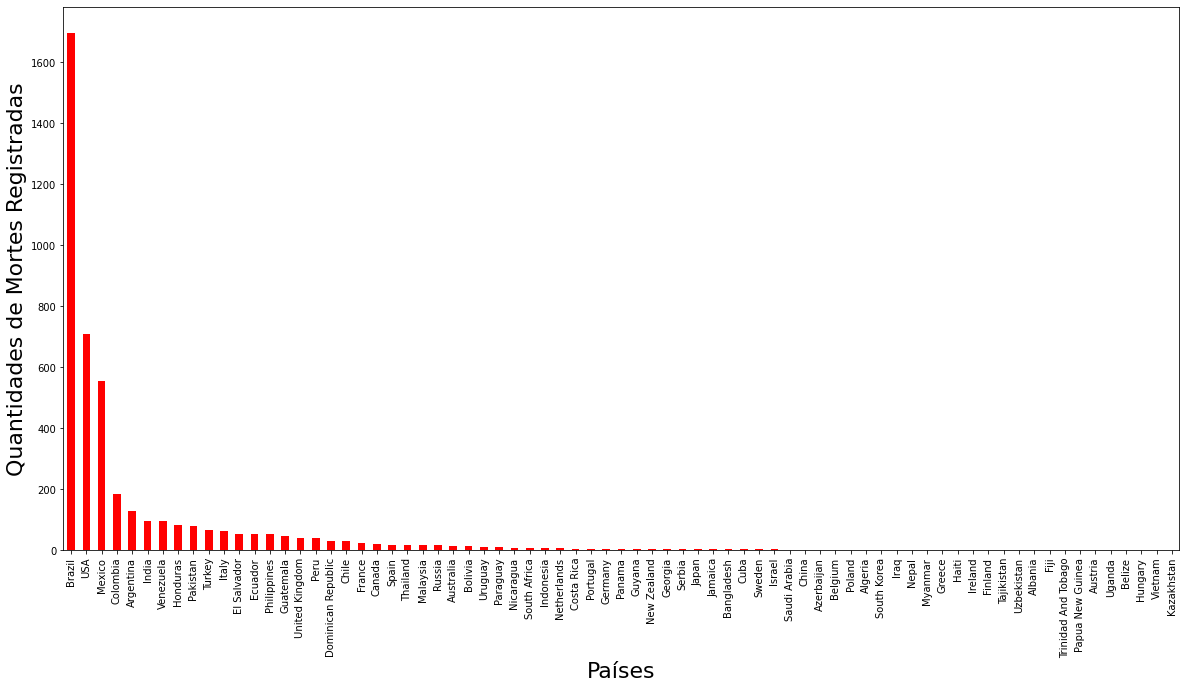

In [52]:
fig = df_paises['Quantidade de casos'].plot.bar(color = 'red', figsize = (20,10))
fig.set_ylabel('Quantidades de Mortes Registradas',{'fontsize': 22})
fig.set_xlabel('Países', {'fontsize': 22})

In [53]:
total_de_casos_pais = df_final.Pais.value_counts()

total_de_casos_brasil = total_de_casos_pais.loc["Brazil"]
total_de_casos_usa = total_de_casos_pais.loc["USA"]
total_de_casos_mexico = total_de_casos_pais.loc["Mexico"]
total_de_casos_discrepantes = total_de_casos_brasil + total_de_casos_usa + total_de_casos_mexico
total_do_geral = total_de_casos_pais.sum()
total_do_restante = total_do_geral - total_de_casos_discrepantes

dados_de_casos ={
'Locais': ['Brasil - USA - Mexico', 'Outros'],
'Quantidade': [total_de_casos_discrepantes, total_do_restante]
}
dados_de_casos = pd.DataFrame(dados_de_casos)


In [54]:
dados_de_casos

Locais  Quantidade
0  Brasil - USA - Mexico        2963
1                 Outros        1417

<AxesSubplot:xlabel='Locais', ylabel='Quantidade'>

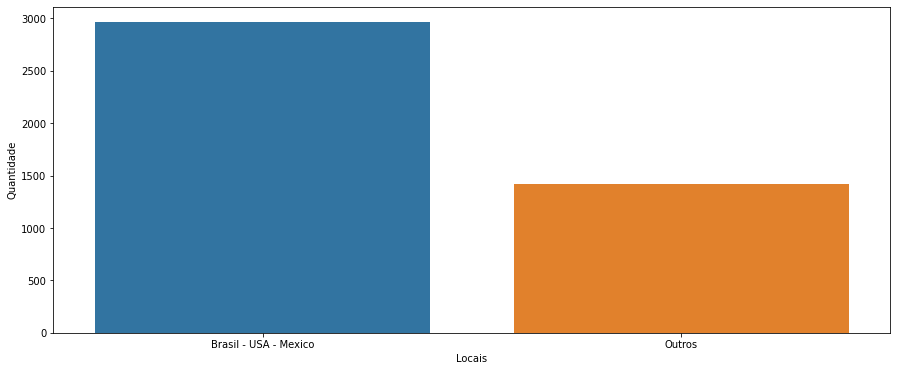

In [55]:
sns.barplot(x= dados_de_casos['Locais'], y = dados_de_casos['Quantidade'], data= dados_de_casos)

## Analise dos paises com menores numero de casoso

In [56]:
df_total_do_restante = df_paises
df_total_do_restante = pd.DataFrame(df_total_do_restante)
df_total_do_restante.drop(['Brazil', 'USA', 'Mexico'], axis = 0, inplace = True)
df_total_do_restante.columns = ['Quantidade de casos']
df_total_do_restante

Quantidade de casos
Colombia                    184
Argentina                   128
India                        97
Venezuela                    96
Honduras                     82
...                         ...
Uganda                        1
Belize                        1
Hungary                       1
Vietnam                       1
Kazakhstan                    1

[70 rows x 1 columns]

Text(0.5, 0, 'Países')

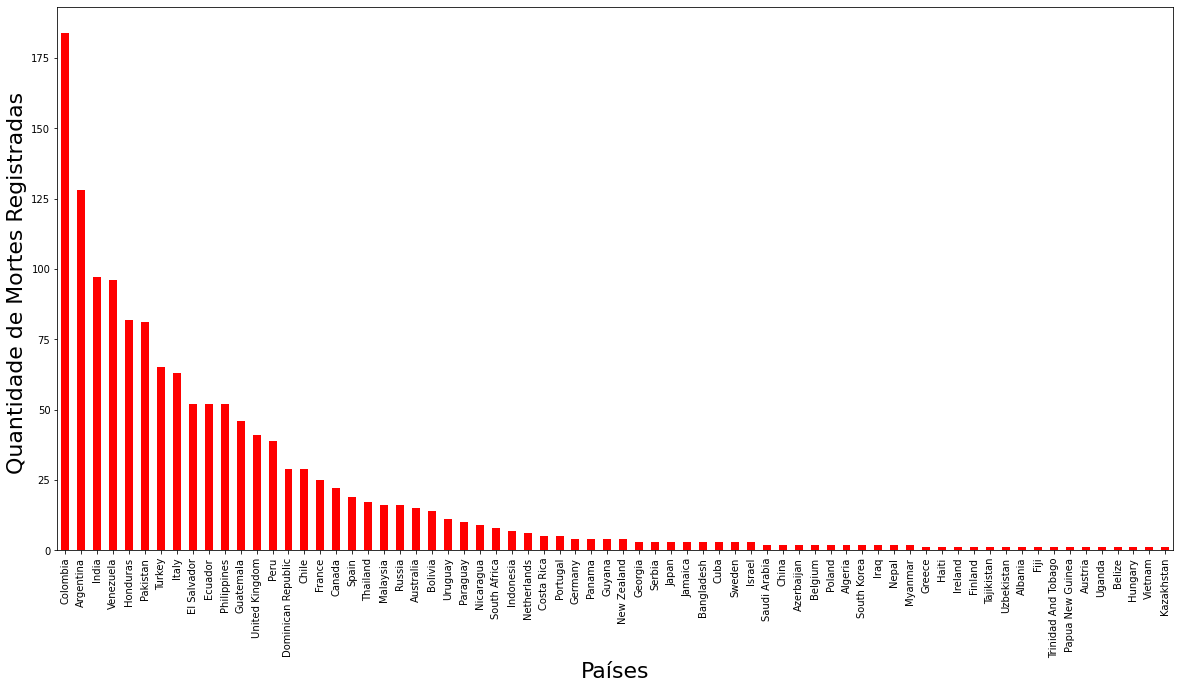

In [57]:
fig = df_total_do_restante['Quantidade de casos'].plot.bar(color = 'red', figsize = (20,10))
fig.set_ylabel('Quantidade de Mortes Registradas ', {'fontsize': 22})
fig.set_xlabel('Países', {'fontsize': 22})

## Visualização dos Dados Para Categoria de Mortes

### Visualização de BarPlot Separados por Categorias de Morte

In [58]:
df_final['Categoria'].unique()

array(['violence', 'medical', 'custodial', 'suicide', 'uncategorised'],
      dtype=object)

In [59]:
df_final['Categoria'].value_counts()
df_categoria = df_final['Categoria'].value_counts()
df_categoria = pd.DataFrame(df_categoria)
df_categoria

Categoria
violence            3691
uncategorised        368
suicide              206
medical               87
custodial             28

In [1]:
df_final['Categoria'].value_counts()
sns.set(style="dark")

category = df_final['Categoria'].unique()
cont = df_final['Categoria'].value_counts()
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(x=category, y=cont)


NameError: name 'df_final' is not defined

## Analise de frequencias 

### Para as categorias das mortes


In [61]:
categoria_counts = df_final['Categoria'].value_counts()

percentual_categoria = df_final['Categoria'].value_counts(normalize = True) * 100

freq_categoria = pd.DataFrame({'Quantidade': categoria_counts, 'Porcentagem (%)': percentual_categoria})

freq_categoria.rename_axis('Categoria', axis= 'columns', inplace = True)

freq_categoria

Categoria      Quantidade  Porcentagem (%)
violence             3691        84.269406
uncategorised         368         8.401826
suicide               206         4.703196
medical                87         1.986301
custodial              28         0.639269

### Para as causas da morte

In [62]:
causa_counts = df_final['Causa da morte'].value_counts()
df_causa = causa_counts.to_frame()
df_causa

Causa da morte
shot                                  1477
stabbed                                787
not reported                           414
beaten                                 361
murdered                               259
...                                    ...
shot and stabbed                         1
tortured and burnt                       1
raped, beaten and drowned                1
beaten, stabbed and burned               1
beaten and burnt                         1

[169 rows x 1 columns]

In [63]:
percentual_causa = df_final['Causa da morte'].value_counts(normalize = True) * 100

freq_causa = pd.DataFrame({'Quantidade': causa_counts, 'Porcentagem (%)': percentual_causa})

freq_causa.rename_axis('Causa da morte', axis= 'columns', inplace = True)

In [64]:
freq_causa.head

<bound method NDFrame.head of Causa da morte              Quantidade  Porcentagem (%)
shot                              1477        33.721461
stabbed                            787        17.968037
not reported                       414         9.452055
beaten                             361         8.242009
murdered                           259         5.913242
...                                ...              ...
shot and stabbed                     1         0.022831
tortured and burnt                   1         0.022831
raped, beaten and drowned            1         0.022831
beaten, stabbed and burned           1         0.022831
beaten and burnt                     1         0.022831

[169 rows x 2 columns]>

### Para efeitos de visualização de dados, será levado em consideração apenas os casos com a frequecia maior que 5

In [65]:
causa_counts

shot                          1477
stabbed                        787
not reported                   414
beaten                         361
murdered                       259
                              ... 
shot and stabbed                 1
tortured and burnt               1
raped, beaten and drowned        1
beaten, stabbed and burned       1
beaten and burnt                 1
Name: Causa da morte, Length: 169, dtype: int64

## Previsão de casos

## Visualizando o aumento de casos de acordo com o tempo

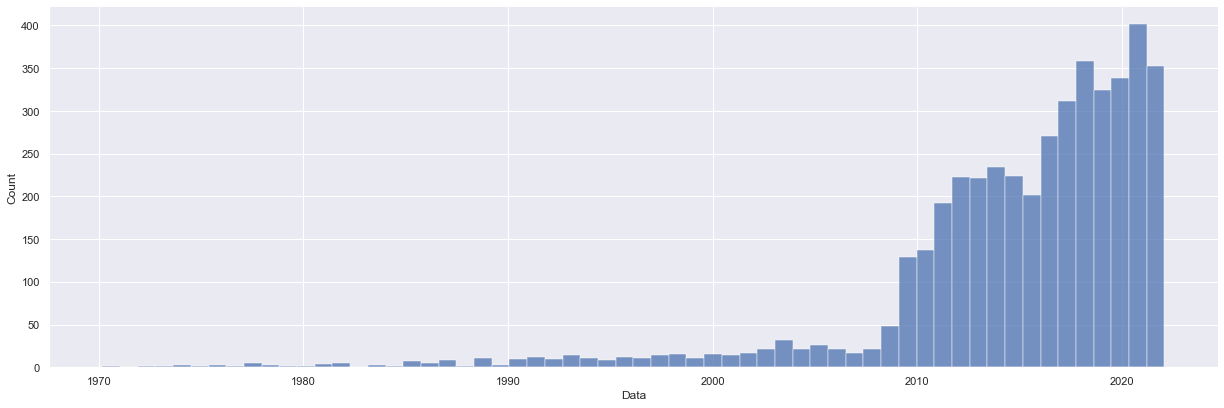

In [66]:
ax = sns.displot(df_final['Data'])
ax.figure.set_size_inches(20,6)

ax

In [67]:
df_data = df.groupby(['Date'])['Name'].count().to_frame()

df_data['Casos totais'] = df_data.Name.cumsum()

df_data

Name  Casos totais
Date                          
1970-03-07     1             1
1972-01-31     1             2
1972-04-21     1             3
1973-01-31     1             4
1973-11-24     1             5
...          ...           ...
2022-01-22     1          4533
2022-01-23     1          4534
2022-01-26     1          4535
2022-01-29     1          4536
2022-01-30     1          4537

[2991 rows x 2 columns]

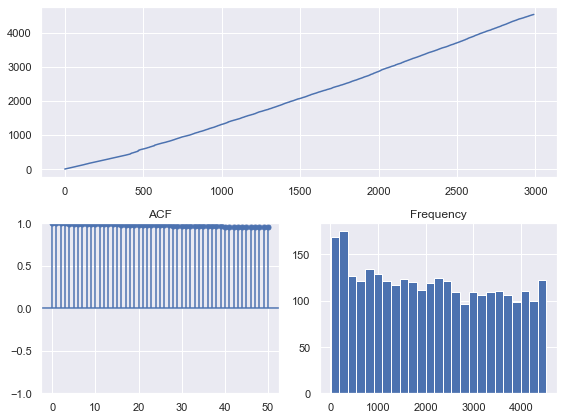

<Figure size 720x1440 with 0 Axes>

In [68]:
tsdisplay(df_data['Casos totais'])
plt.savefig('display.jpeg', format='jpeg')

In [69]:
stepwise=auto_arima(df_data[['Casos totais']], start_p=0, start_q=0, d=0, max_p=6, max_q=6, max_d=2, start_P=1, start_Q=1, D=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=7, seasonal=True, trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=13764.462, Time=16.18 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=14404.990, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=9116.671, Time=10.70 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=12133.252, Time=2.35 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=22761.778, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=9877.182, Time=0.98 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=8836.917, Time=18.19 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=22.34 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=15.12 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=13977.531, Time=15.32 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=8838.181, Time=20.55 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=8838.115, Time=30.19 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=11978.154, Time=13.65 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=8840.913, Time=29.42 sec
 ARIMA(1,0,0)(2,1,0)[7]    

In [70]:
stepwise

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 7),
      suppress_warnings=True)

In [71]:
print(stepwise.aic())
print(stepwise.bic())

8836.916957897174
8866.922057703792


In [72]:
treino=df_data[['Casos totais']].loc['1970-03-07':'2020-12-01']
teste=df_data[['Casos totais']].loc['2021-01-01':]

In [73]:
treino

Casos totais
Date                    
1970-03-07             1
1972-01-31             2
1972-04-21             3
1973-01-31             4
1973-11-24             5
...                  ...
2020-11-26          4022
2020-11-27          4023
2020-11-29          4026
2020-11-30          4028
2020-12-01          4032

[2682 rows x 1 columns]

In [74]:
teste

Casos totais
Date                    
2021-01-01          4072
2021-01-02          4074
2021-01-04          4075
2021-01-06          4077
2021-01-07          4078
...                  ...
2022-01-22          4533
2022-01-23          4534
2022-01-26          4535
2022-01-29          4536
2022-01-30          4537

[283 rows x 1 columns]

In [75]:
stepwise.fit(treino)
previsao =stepwise.predict(n_periods=283)
previsao = pd.DataFrame(previsao,index=teste.index, columns=['previsão modelo 1'])

previsao

previsão modelo 1
Date                         
2021-01-01        4033.832561
2021-01-02        4035.027088
2021-01-04        4036.194254
2021-01-06        4037.060846
2021-01-07        4039.288873
...                       ...
2022-01-22        4455.918440
2022-01-23        4458.666910
2022-01-26        4460.139514
2022-01-29        4461.137375
2022-01-30        4461.973541

[283 rows x 1 columns]

<Figure size 1440x360 with 0 Axes>

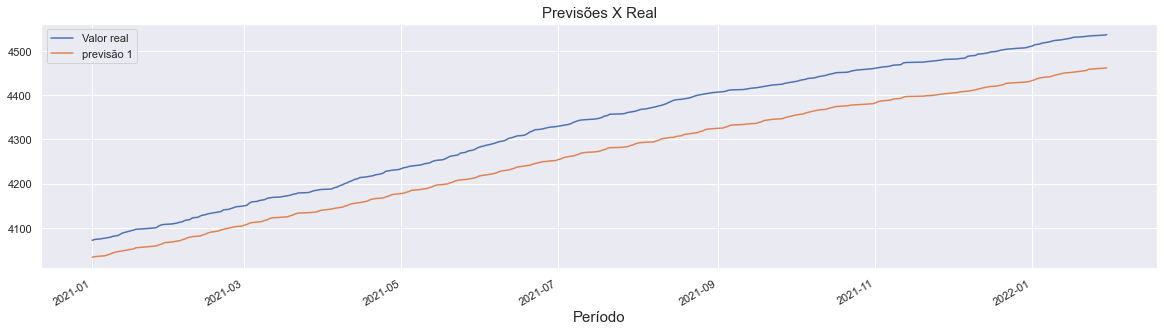

In [76]:
plt.figure(figsize=(20,5))
pd.concat([teste,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1']);



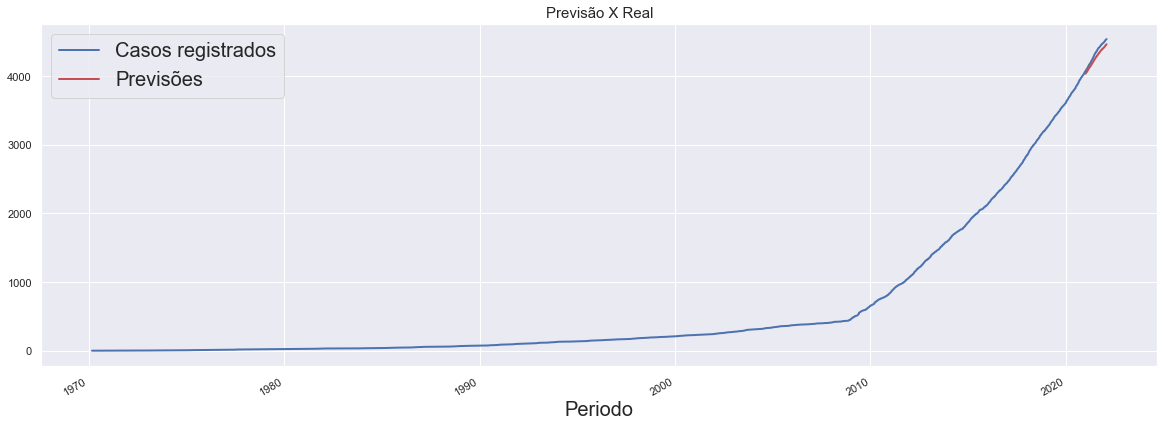

In [77]:
pd.concat([df_data[['Casos totais']],previsao], axis=1).plot(linewidth=2, figsize=(20,7), color=['b','r'])
plt.legend(['Casos registrados','Previsões'], fontsize=20)
plt.xlabel('Periodo', size=20)
plt.title('Previsão X Real',size=15)
plt.show()

In [78]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2682
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood               -3977.807
Date:                           Mon, 20 Jun 2022   AIC                           7965.614
Time:                                   17:41:24   BIC                           7995.072
Sample:                                        0   HQIC                          7976.272
                                          - 2682                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7194      0.122      5.915      0.000       0.481       0.958
ar.L1          0.9649      0.005    178.106      0.000       0.954       0.976
ar.S.L7       -0.6432      0.008    -78.202      0.000      -0.659      -0.627
ar.S.L14      -0.3054      0.008    -36.245      0.000      -0.322      -0.289
sigma2         1.1438      0.008    149.266      0.000       1.129       1.159
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):            219763.17
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             3.50
Prob(H) (two-sided):                  0.52   Kurtosis:                        46.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Area de analise do modelo SARIMAX


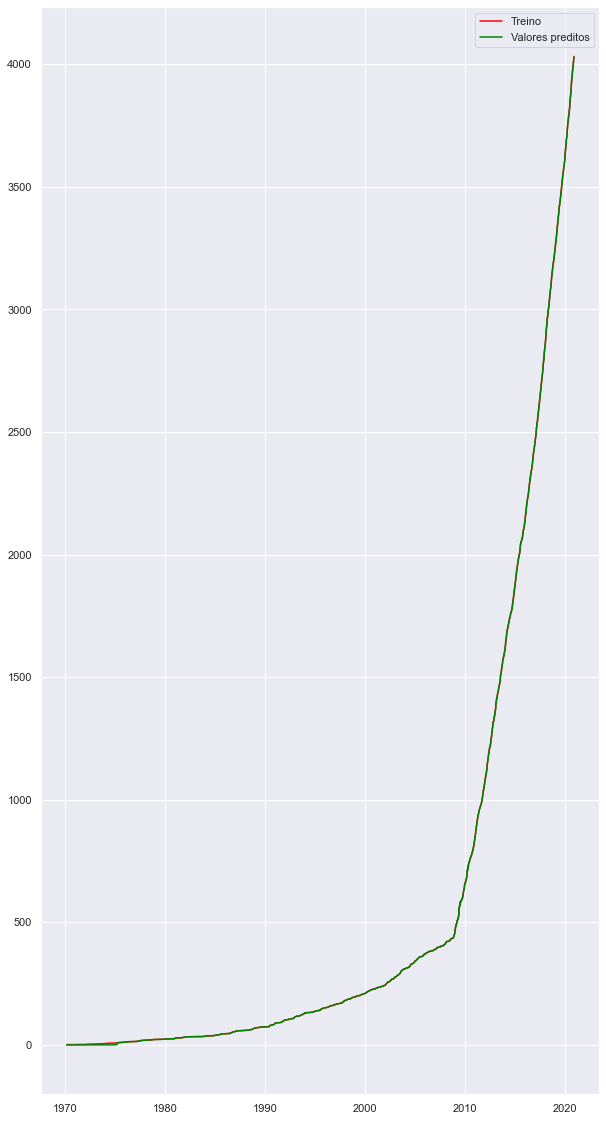

In [79]:
modelo = SARIMAX(treino, order=(1,0,0), seasonal_order=(2,1,0,7)).fit(disp=0)

predito = modelo.predict(typ='levels')
plt.plot(treino, color='red')
plt.plot(predito,color='green')
plt.legend(['Treino','Valores preditos'])

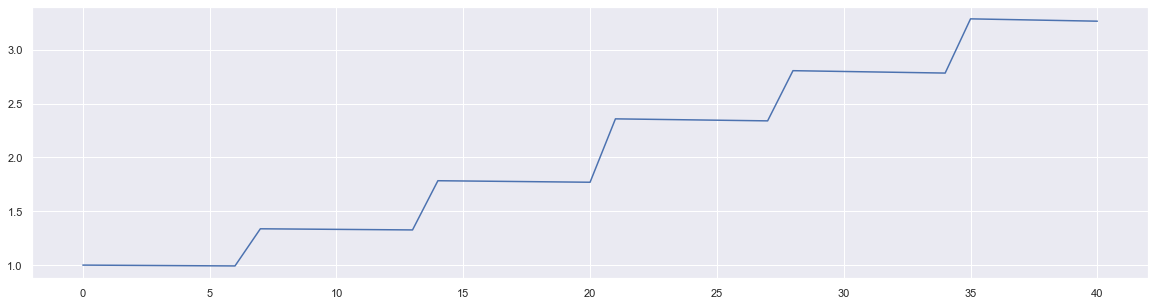

In [80]:
modelo.impulse_responses(steps=40).plot(figsize=(20,5));

In [81]:
print("RMSE do modelo 1: %.3f" % np.sqrt(mean_squared_error(treino, predito)))
print("R² do modelo 1: %.3f" % r2_score(treino, predito))
print(''*254)
print("RMSE do modelo 2: %.3f" % np.sqrt(mean_squared_error(teste, previsao)))
print("R² do modelo 2: %.3f" % r2_score(teste, previsao))

RMSE do modelo 1: 1.109
R² do modelo 1: 1.000

RMSE do modelo 2: 66.370
R² do modelo 2: 0.766


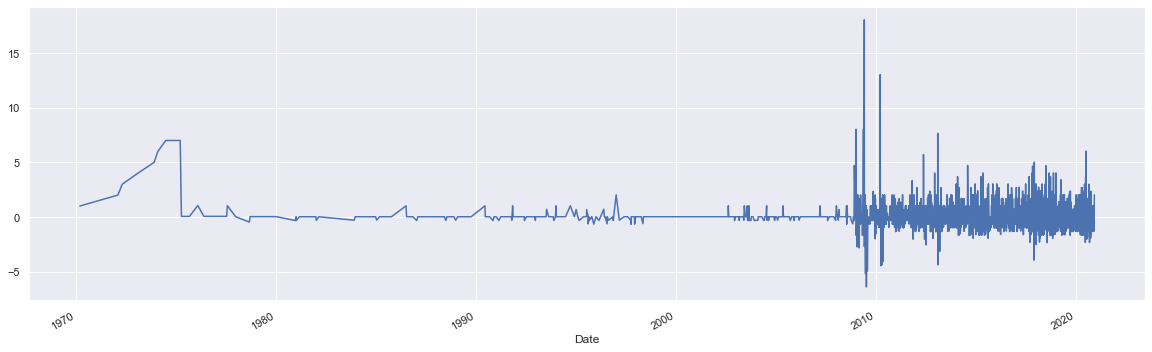

In [82]:
(treino['Casos totais'] - pd.DataFrame(predito)['predicted_mean']).plot(figsize=(20,6));

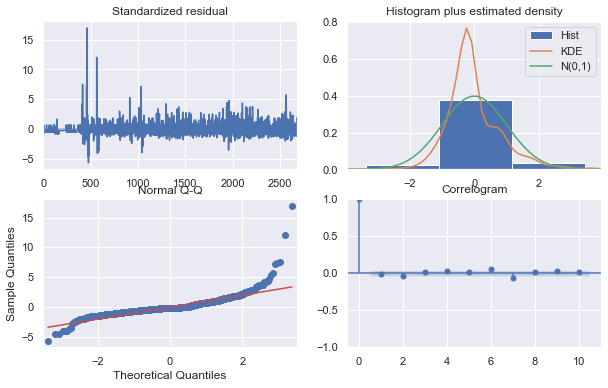

In [83]:
stepwise.plot_diagnostics(figsize=(10,6));

In [84]:
erro_previsto1 = treino['Casos totais'] - pd.DataFrame(predito)['predicted_mean']
jb1 = jarque_bera(erro_previsto1)
print('Estatística Jarque-Bera :', jb1[0])
print('p-valor :', jb1[1])
print('Assimetria :', jb1[2])
print('Curtose :',jb1[3])


Estatística Jarque-Bera : 173180.08243853308
p-valor : 0.0
Assimetria : 3.253782189019427
Curtose : 41.824753905597156


In [85]:
erro_previsto2 = teste['Casos totais'] - previsao['previsão modelo 1']
jb2 = jarque_bera(erro_previsto2)
print('Estatística Jarque-Bera :', jb2[0])
print('p-valor :', jb2[1])
print('Assimetria :', jb2[2])
print('Curtose :',jb2[3])

Estatística Jarque-Bera : 34.091522983090684
p-valor : 3.9547573728887075e-08
Assimetria : -0.4970790032897815
Curtose : 1.6205784725064363


In [86]:
stepwise.fit(df_data[['Casos totais']])

previsao2 = stepwise.predict(n_periods=486)

previsao2 = pd.DataFrame(previsao2, 
                              index=pd.date_range(start='2022-02-01', end='2023-06-01',), columns=['nova previsão'])

In [87]:
previsao2

nova previsão
2022-02-01    4539.101101
2022-02-02    4540.538851
2022-02-03    4542.244489
2022-02-04    4543.335201
2022-02-05    4544.422693
...                   ...
2023-05-28    5262.564686
2023-05-29    5264.082230
2023-05-30    5266.313961
2023-05-31    5267.868455
2023-06-01    5269.397368

[486 rows x 1 columns]

<Figure size 1440x360 with 0 Axes>

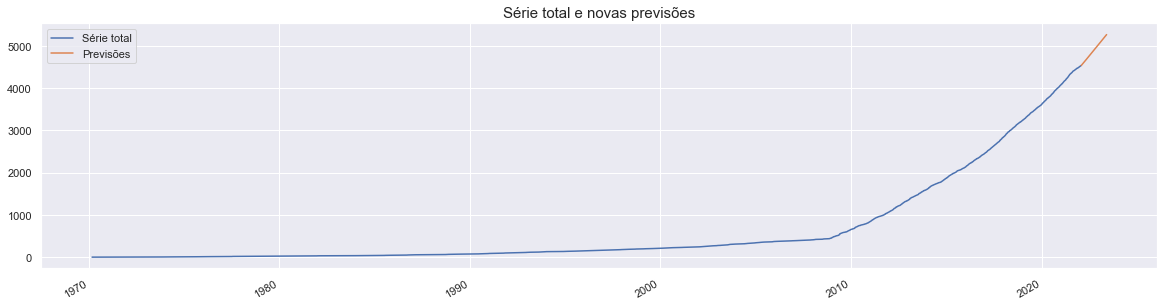

<Figure size 720x1440 with 0 Axes>

In [88]:
plt.figure(figsize=(20,5))
pd.concat([df_data[['Casos totais']],previsao2],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Série total e novas previsões',size=15)
plt.legend(['Série total','Previsões'])
plt.show()


## Paineis de Analise

In [95]:
import plotly.express as px
fig = px.area(df_final, 
              x="Data", 
              y=df_final.Nome, 
              color='Pais', 
              height=600,
              title='Casos ao longo do tempo')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [96]:
fig = px.choropleth(df_final,                                                      # casos agrupados por país
                    locations="Pais",                                    # definindo as regiões no mapa
                    locationmode='country names',                                  # define o modo de localização para todas regiões
                    color=np.log(df_final["Nome"]),                                # define a cor pelo o valor de casos confirmados (aplica o log)
                    hover_name='Pais',                                   # define o texto interativo com o nome da região
                    hover_data=["Pais", "Causa da morte"],                         # define o texto interativo com o numero de casos confirmasos e mortes
                    animation_frame=df_final["Data"].dt.strftime('%d-%m-%Y'),   # define o animate_frame com as datas
                    title='Casos ao longo do tempo',                               # define título
                    color_continuous_scale=px.colors.sequential.Magenta)           # define a paleta de cores
fig.update_layout(autosize=False, width=1200, height=800)                          # define tamanho da figura
fig.show()

In [91]:
df_painel_de_paises = df_final["Pais"].value_counts().to_frame().reset_index()
df_painel_de_paises.columns = ['Pais', 'Quantidade']
df_painel_de_paises

Pais  Quantidade
0       Brazil        1697
1          USA         710
2       Mexico         556
3     Colombia         184
4    Argentina         128
..         ...         ...
68      Uganda           1
69      Belize           1
70     Hungary           1
71     Vietnam           1
72  Kazakhstan           1

[73 rows x 2 columns]

In [97]:
fig = px.treemap(df_painel_de_paises.sort_values(by='Pais', ascending=False).reset_index(drop=True), 
                 path=["Pais"],
                 values="Quantidade",
                 height=600,
                 title='Número de Casos Confirmados',
                 color_discrete_sequence = px.colors.qualitative.Dark2)
fig.data[0].textinfo = 'label+text+value'
fig.show()